# Introduction

I recently starting collecting data from the [BART API](http://www.bart.gov/schedules/developers/api), specifically estimated time to departure for trains at the two stations I use most frequently. In this notebook I'll show how I parsed the data from a csv file, reshaped it to fit the questions at hand, and made a few plots. [Download notebook](https://github.com/frankcleary/data-science-bytes/blob/master/content/bart-reshape-plot.ipynb).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

def prettify_axis(ax, ylabel='', xlabel=''):
    label_format_dict = dict(fontsize=20, fontweight='bold')
    tick_format_dict = dict(labelsize=16, direction='out', top='off', right='off', 
                            length=4, width=1)
    ax.set_xlabel(xlabel, label_format_dict)
    ax.set_ylabel(ylabel, label_format_dict)
    ax.tick_params(**tick_format_dict)

The file [`plza.csv`](/data/plza.csv) contains the data obtained from the BART API for trains leaving the El Cerrito Plaza station with the timestamp, train destination, train direction, number of cars, and estimated departure time.

In [2]:
!head data/plza.csv

time,dest,dir,len,etd
1417108837.85,Fremont,South,6,3
1417108837.85,Richmond,North,6,10
1417108921.12,Fremont,South,6,2
1417108921.12,Richmond,North,6,9
1417108981.46,Fremont,South,6,Leaving
1417108981.46,Richmond,North,6,7
1417109041.84,Fremont,South,6,20
1417109041.84,Richmond,North,6,6
1417109101.18,Fremont,South,6,19


# Parsing the data

To convert the timestamp into a pandas datetime I wrote a custom date parsing funcion, which also converts to Pacific time.

In [3]:
def parse_time(timestamp):
    try:
        dt = pd.to_datetime(float(timestamp), unit='s')
        return dt.tz_localize('UTC').tz_convert('US/Pacific')
    except AttributeError, ValueError:
        return pd.NaT

Here I read in the data using the date parser defined above. I also do a bit of cleanup, replacing data points where the train is "Leaving" with an estimated departure time of 0 minutes.

In [4]:
df = pd.read_csv('data/plza.csv', parse_dates=['time'], date_parser=parse_time)
df['etd'] = df['etd'].replace('Leaving', 0).astype(np.float) 
df.head()

,time,dest,dir,len,etd
0,2014-11-27 09:20:37.850000-08:00,Fremont,South,6,3
1,2014-11-27 09:20:37.850000-08:00,Richmond,North,6,10
2,2014-11-27 09:22:01.120000-08:00,Fremont,South,6,2
3,2014-11-27 09:22:01.120000-08:00,Richmond,North,6,9
4,2014-11-27 09:23:01.460000-08:00,Fremont,South,6,0


I take the Millbrae train to work, so I'm most interested in its data. Here I filter the DataFrame to keep only data for trains going to Millbrae.

In [5]:
df_mill = df[df['dest'] == 'Millbrae']
df_mill.head(3)

,time,dest,dir,len,etd
1992,2014-11-28 03:29:01.120000-08:00,Millbrae,South,5,52
1994,2014-11-28 03:30:01.460000-08:00,Millbrae,South,5,51
1996,2014-11-28 03:31:01.810000-08:00,Millbrae,South,5,50


# Reshaping the data

To investigate the daily variability in estimated departure times, I want each date be a column of data with the time of day as the index. To do this I'll do a few transformations on the `time` column to extract the dates and the time of day, then use a pivot table to reshape the data.

In [6]:
df_mill['time_of_day'] = df['time'].apply(lambda x: datetime.time(x.time().hour, x.time().minute))
df_mill['date'] = df['time'].apply(lambda x: x.date())
mill_pivot = df_mill.pivot(index='time_of_day', columns='date', values='etd')
mill_pivot.ix[:3, :4]

date,2014-11-28,2014-12-01,2014-12-02,2014-12-03
time_of_day,,,,
03:29:00,52,52,52,52
03:30:00,51,51,51,51
03:31:00,50,50,50,50


# Plots

Now I'll plot a line for each day. If the trains are on schedule each line should overlap in a sawtooth pattern. If BART's estimated times are correct the lines should have a slope of 1 everywhere they are differentiable (the estimated time to departure should decrease 1 minute per minute). In the weeks covered by this data the there are a few days where significant deviations occured.

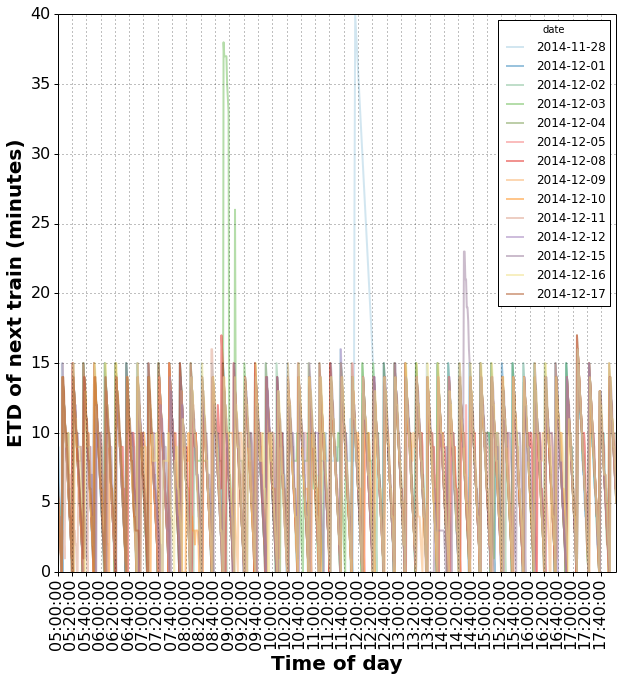

In [7]:
PLOT_ARGS = dict(figsize=(10, 10), cmap='Paired', lw=2, alpha=.5, ylim=[0, 40],
                 xlim=[datetime.time(5, 0), datetime.time(18, 0)])
X_TICKS = [datetime.time(hour, minute) 
            for minute in xrange(0, 60, 20) 
            for hour in xrange(5, 18)]
ax = mill_pivot.plot(**PLOT_ARGS)
prettify_axis(ax, xlabel='Time of day', ylabel='ETD of next train (minutes)')
plt.xticks(X_TICKS, rotation=90);

To focus on the dates where something went wrong, this function emphasizes the line for a given date.

In [8]:
def emphasize_date(pivot_table, date, plot_args=PLOT_ARGS, xticks=X_TICKS):
    ax = pivot_table.plot(**plot_args)
    prettify_axis(ax, xlabel='Time of Day', ylabel='ETD of next train (minutes)')
    ax.set_title(date, fontsize=24)
    for lines in zip(ax.get_lines(), ax.get_legend().get_lines()):
        if lines[0].get_label() == str(date):
            plt.setp(lines, lw=2, zorder=10, alpha=1, color='r')
        else:
            plt.setp(lines, alpha=.5)
    plt.xticks(xticks, rotation=90);

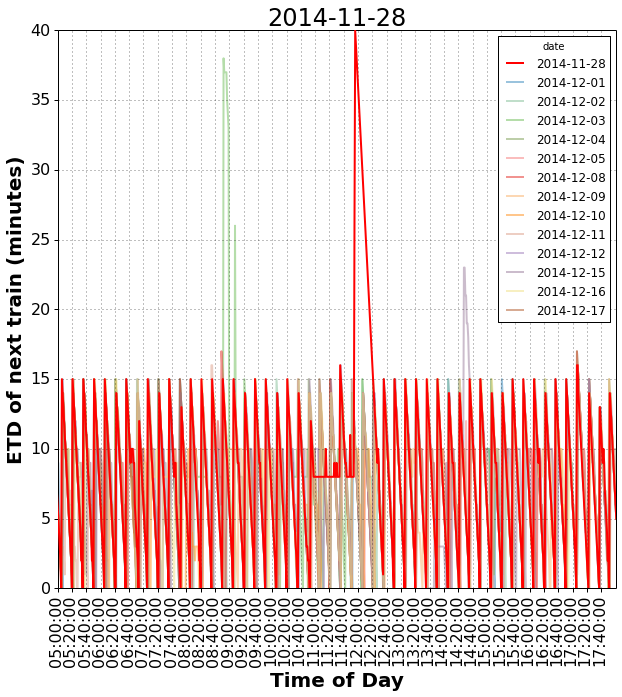

In [9]:
emphasize_date(mill_pivot, datetime.date(2014, 11, 28))

The Millbrae trains are scheduled to come every 15 minutes, below is a histogram of the actual time between trains. In general much of the data is within a few minutes of this ideal, although there are times when the trains are spread out or clustered.

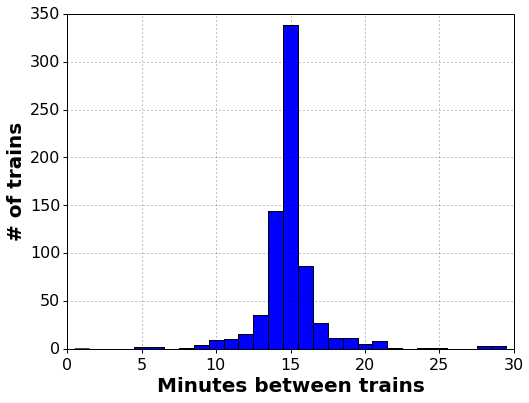

In [10]:
leaving_times = df_mill[df_mill['etd'] == 0]['time']
arrival_diff_minutes = pd.to_datetime(leaving_times).diff() / np.timedelta64(1, 'm')
sele = (arrival_diff_minutes > 2) & (arrival_diff_minutes < 30) 
ax = arrival_diff_minutes[sele].hist(figsize=(8, 6), bins=np.arange(.5, 30, 1))
prettify_axis(ax, xlabel='Minutes between trains', ylabel='# of trains')